In [1]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from cv_paper_plots import accuracy, slope, analysis

from cv_paper_plots.style import letter_fontstyle

from importlib import reload

In [2]:
subjects = ['ec2', 'ec9', 'gp31', 'gp33']

In [3]:
with open(os.path.join(os.environ['HOME'], 'plots/model/data/frac_results.pkl'), 'rb') as f:
    deep_all, linear_all, _ = pickle.load(f, encoding='latin1')

d = np.load(os.path.join(os.environ['HOME'], 'plots/ds/data/dataset_chance.npz'))
chance = d['chance_data']
training_size = d['training_size']

In [4]:
other_linear_accuracy = {}
other_deep_accuracy = {}
for key in ['c', 'v', 'p', 'm']:
    other_linear_accuracy[key] = np.zeros((len(subjects), 3, 10))
    other_deep_accuracy[key] = np.zeros((len(subjects), 3, 10))
for ii, s in enumerate(subjects):
    for style in ['_lin', '']:
        f_string = 'plots/model/data/{}_{}_hg_a{}_model_output.pkl'.format(s, s, style)
        with open(os.path.join(os.environ['HOME'], f_string), 'rb') as f:
            dicts, dicts2, y_dims, has_data = pickle.load(f, encoding='latin1')
        indices_dicts2, y_hat_dicts2, logits_dicts2 = dicts2
        mats = analysis.indx_dict2conf_mat(indices_dicts2, y_dims)
        c_mat, v_mat, cv_mat = mats
        acc = analysis.conf_mat2accuracy(c_mat, v_mat, cv_mat)
        (c_accuracy, v_accuracy, cv_accuracy, accuracy_per_cv,
         p_accuracy, m_accuracy) = acc
        if style == '_lin':
            d = other_linear_accuracy
        else:
            d = other_deep_accuracy
        d['c'][ii, 2] = c_accuracy
        d['v'][ii, 2] = v_accuracy
        d['p'][ii, 2] = p_accuracy
        d['m'][ii, 2] = m_accuracy

In [5]:
fracs = sorted(deep_all.keys())

# CV Accuracy and Slop

CV classification accuracy (XX way) improves from 13.1 $\pm$ 7.4\%  to 19.9 $\pm$ 12.6\% across subjects for logistic regression compared to deep networks respectively. The highest single subject cv accuracies are for Subject 1 which are 23.6$\pm$ 2.1\% (13 times chance, 1.8\%) and 38.3$\pm$ 2.9\% (22 times chance, 1.8\%) for logistic regression and deep networks respectively, which is a 63.1\% improvement.
Cons. classification accuracy (XX way) improves from 21.4 $\pm$ 8.7\%  to 26.8 $\pm$ 12.6\% across subjects for logistic regression compared to deep networks respectively. The highest single subject cons. accuracies are for Subject 1 which are 34.0$\pm$ 1.5\% (7 times chance, 5.2\%) and 44.9$\pm$ 3.0\% (9 times chance, 5.2\%) for logistic regression and deep networks respectively, which is a 32.4\% improvement.
Vowel classification accuracy (XX way) improves from 45.7 $\pm$ 8.8\%  to 51.7 $\pm$ 12.1\% across subjects for logistic regression compared to deep networks respectively. Th

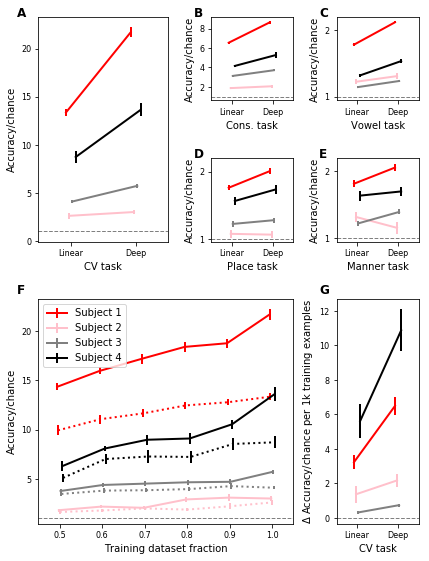

In [7]:
reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(6, 8))

le = .1
re = .02
te = .02
be = .1
h_gap = .1
v_gap = .1

cv_w = .3
big_h = (1. - te - be - v_gap) / 2.
little_h = (1. - te - be - 2 * v_gap - big_h) / 2.
ax_cv = f.add_axes([le, be + big_h + v_gap, cv_w, big_h])

w = (1. - le - cv_w - h_gap - h_gap - re) / 2.
h = (1. - te - v_gap - be) / 2.
r_x = le + cv_w + h_gap
c_v_y = be + big_h + v_gap + little_h + v_gap
ax_c = f.add_axes([r_x, c_v_y, w, little_h])
ax_v = f.add_axes([r_x + w + h_gap, c_v_y, w, little_h])

p_m_y = be + big_h + v_gap
ax_p = f.add_axes([r_x, p_m_y, w, little_h])
ax_m = f.add_axes([r_x + w + h_gap, p_m_y, w, little_h])

ax_lines = f.add_axes([le, be, cv_w + h_gap + w, h])
ax_slopes = f.add_axes([le + cv_w + 2 * h_gap + w, be, w, big_h])

key = fracs[-1]

accuracy.plot_cv_accuracy(subjects, deep_all[key], linear_all[key], chance[0, :, -1], ax_cv, legend=False)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['c'], other_linear_accuracy['c'],
                          chance[1, :, -1], ax_c, 'Cons. task', False, ymax=9.2)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['v'], other_linear_accuracy['v'],
                          chance[2, :, -1], ax_v, 'Vowel task', False, ymax=2.2)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['p'], other_linear_accuracy['p'],
                          chance[3, :, -1], ax_p, 'Place task', False, ymax=2.2)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['m'], other_linear_accuracy['m'],
                          chance[4, :, -1], ax_m, 'Manner task', False, ymax=2.2)

slope.plot_cv_slope(subjects, deep_all, linear_all, chance[0], training_size, fracs, (ax_lines, ax_slopes),
                    legend=True)

x0 = .05
y0 = c_v_y + little_h
x1 = .46
y1 = p_m_y + little_h
x2 = .75
y3 = .5

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)
f.text(x2, y0, 'C', **letter_fontstyle)
f.text(x1, y1, 'D', **letter_fontstyle)
f.text(x2, y1, 'E', **letter_fontstyle)
f.text(x0, y3, 'F', **letter_fontstyle)
f.text(x2, y3, 'G', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy_slope.pdf'))